# Accessing Variables in Jets & MC

This short notebook shows how to access jets and MC particles in a dataset so that you can get the awkward information local.

Some of this code is common and may be best put into files to be separate libraries or modules.

## Datasets

We'll have two datasets here (we can get more if we want).

* `dijet` - These are simple QCD 2-jet production runs. These are very much Standard Model events. The dataset is actually HUGE. I've limited it to 20 files worth of events, but you can increase it if you want. But the first query will take a lot longer if you do that!
* `llp` - These are Hidden Valley (a type of Hidden Sector) simulation. They contain the long lived particles we are interested in. And this is where you'll do most of your testing.

In [1]:
ds_dijet_rucio = "rucio://mc16_13TeV.361022.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ2W.deriv.DAOD_EXOT15.e3668_s3126_r9364_r9315_p4696?files=20&get=available"
ds_llp_rucio = "rucio://mc16_13TeV.311423.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH600_mS150_lthigh.deriv.DAOD_EXOT15.e7357_e5984_s3234_r10201_r10210_p4696"

Create the datasets

In [2]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21, calib_tools
ds_dijet = SXDSAtlasxAODR21(ds_dijet_rucio)
ds_llp = SXDSAtlasxAODR21(ds_llp_rucio)

## Accessing the AntiKt4 jets & PFLow jets


Everything in ATLAS is stored as a collection _name_. There are two for the particle flow and the antikt4 jets:

In [ ]:
jets_pflow_name = "AntiKt4EMPFlowJets"
jets_antikt_name = "AntiKt4EMTopoJets"

Lets get the two types of jets.

In [ ]:
jets_pflow = (
    ds_dijet.Select(lambda e: e.Jets(uncalibrated_collection=jets_pflow_name))
    .Select(lambda e: e.Where(lambda j: (j.pt() / 1000) > 30))
    .Select(lambda e: e.Select(lambda j: (j.pt() / 1000)))
    .AsAwkwardArray("JetPt")
    .value()
)

jets_antikt = (
    ds_dijet.Select(lambda e: e.Jets(uncalibrated_collection=jets_antikt_name))
    .Select(lambda e: e.Where(lambda j: (j.pt() / 1000) > 30))
    .Select(lambda e: e.Select(lambda j: (j.pt() / 1000)))
    .AsAwkwardArray("JetPt")
    .value()
)

Do a quick plot of the number of jets in each event that is about 30 GeV:

In [ ]:
from matplotlib import pyplot as plt
import awkward as ak

plt.hist(ak.count(jets_pflow['JetPt'], axis=-1), bins=10, range=(0, 10), label='PFlow', histtype='step')
plt.hist(ak.count(jets_antikt['JetPt'], axis=-1), bins=10, range=(0, 10), label='AntiKt', histtype='step')
plt.xlabel('Number of jets')
plt.ylabel('Number of events')
plt.title('DiJet MonteCarlos (JZ2W)')
plt.legend()
plt.show()


## Monte Carlo Particles

Next, lets go after the MC particles. For this we need to look at an actual LLP dataset. Every particle has an ID, and for the LLP it is number 35. And that is the only one we are interested in looking at. To see what other possible particleID numbers are, check out the Particle Data Group's pdgID tables.

In [16]:
llp_particles = (ds_llp
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 10)
                 .Where(lambda tp: abs(tp.pdgId()) == 35)
                 .Select(lambda tp: {
                         'pt': tp.pt() / 1000.0,
                         'pdgId': tp.pdgId(),
                 })
                 .AsAwkwardArray()
                 .value()
)

rucio://mc16_13TeV.3...:   0%|                                                                                …

        rucio://mc16_13TeV.3... Downloaded:   0%|                                                             …

Look at how many events were in this dataset - close to the nominal 100,000:

In [18]:
llp_particles, len(llp_particles)

(<Array [{pt: 320, pdgId: 35}, ... pdgId: 35}] type='99915 * {"pt": float64, "pdg...'>,
 99915)

And the $p_T$ of the LLP - which really depends on the mass difference between the scalar and the decaying LLP. From the name of the dataset used above: `_mH600_mS150_`, it is a $m_\Phi=600$ and a $m_{LLP} = 150$.

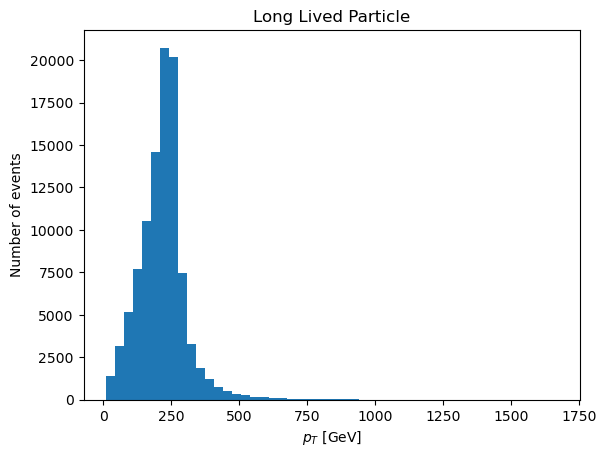

In [21]:
from matplotlib import pyplot as plt
import awkward as ak

plt.hist(llp_particles.pt, bins=50)
plt.xlabel('$p_T$ [GeV]')
plt.ylabel('Number of events')
plt.title('Long Lived Particle')

plt.show()

## Detector Layout & Decays we should detect

LLP's can decay anywhere in the detector and we need different strategies to detect them. We are really only interested in ones that decay in or near the calorimeter. So we need to define a fiducial volume that represents the calorimeter. If the LLP decays in there, then we should see it, if it decays outside, then we don't care if we see it. When doing comparisons between jet performance it will likely be important to look at these two regions.

### Forward vs Central

The [ATLAS detector](https://www.researchgate.net/figure/The-ATLAS-detector-layout-40_fig3_289254690) has forward and central calorimeters. So we need a crude way to split the LLP decays into forward or central decays. We do this by looking at the $\eta$ of the decay ($\eta$ is like the polar angle, $\theta$, and is called [psudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity)). The cut is made at $1.4$. So, central decays are for $\eta < 1.4$, and forward are for the rest.

In [9]:
eta_central_split = 1.4

Next we need cuts on the decay position of the LLP. I've used some trigger plots to figure this out (form a detailed analysis note). First for $x-y$:

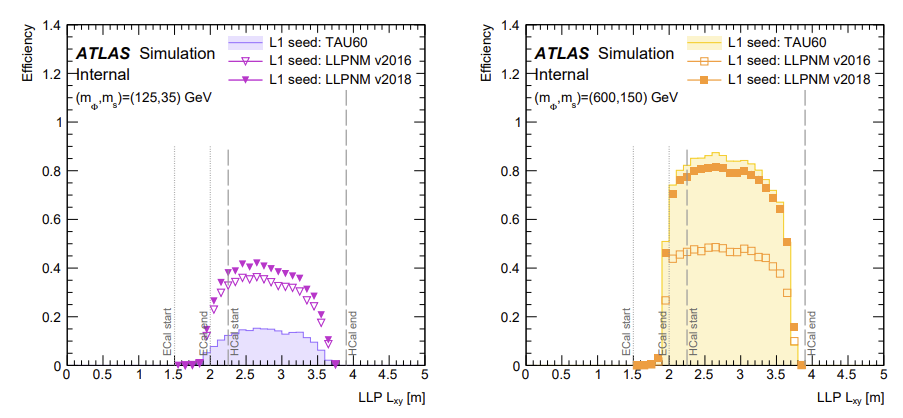

And for $z$

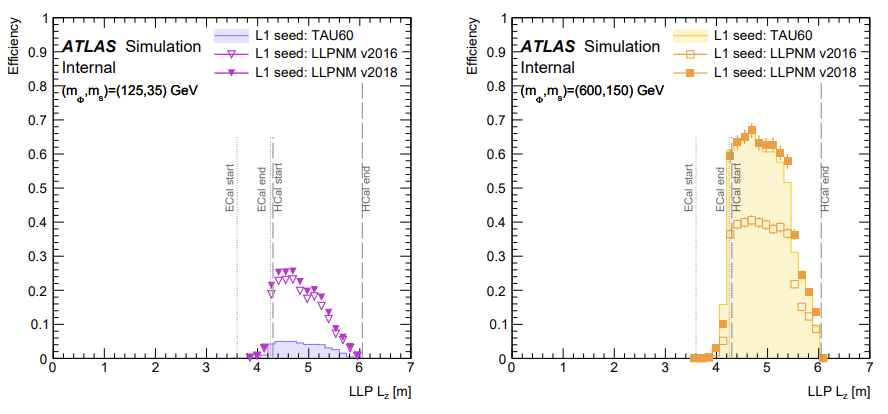

In [10]:
lxy_limits = (1.8, 4)
lz_limits = (4.0, 6.0)

We can use these below with the $x-y$ and $z$ positions. Lets grab the data and make a few plots.

## Decay Length

Technically, the decay length is how far the LLP traveled before it decayed. What we are really interested in, however, is "did the LLP decay in the calorimeter. So, all we care about is: where did the LLP decay?

Lets build a query that gets all the information we need to see if one of the LLP's decayed in the calorimeter. Note that distances are measured in `mm` in ATLAS - and it is easier to think about the detector in meters (which the above cuts are in).

NOTE: There should be a way to take the `sqrt` for $L_xy$ below, but that isn't working. I'll update this when I figure that out.

In [22]:
from math import sqrt

llp_particles = (ds_llp
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 10)
                 .Where(lambda tp: abs(tp.pdgId()) == 35)
                 .Where(lambda tp: tp.hasDecayVtx())
                 .Select(lambda tp: {
                         'pt': tp.pt() / 1000.0,
                         'eta': tp.eta(),
                         'Lz': tp.decayVtx().z() / 1000.0,
                         'Lxy': (tp.decayVtx().x()**2 + tp.decayVtx().y()**2) / (1000.0*1000.0),
                         'pdgId': tp.pdgId(),
                 })
                 .AsAwkwardArray()
                 .value()
)

rucio://mc16_13TeV.3...:   0%|                                                                                …

        rucio://mc16_13TeV.3... Downloaded:   0%|                                                             …

Demonstrate where in $\eta$ we have the forward and central parts of the detector

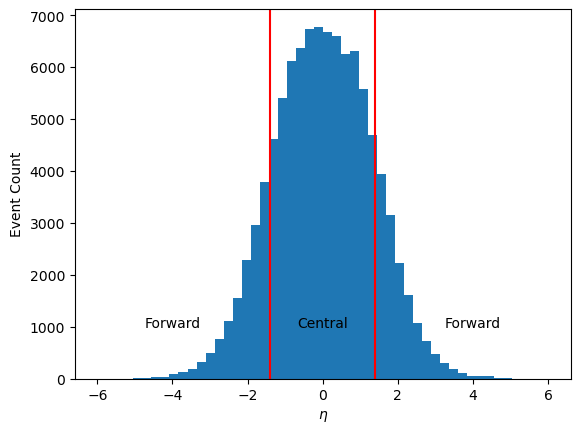

In [26]:
from matplotlib import pyplot as plt
import awkward as ak
import numpy as np

plt.hist(llp_particles.eta, bins=50, range=(-6, 6))
plt.xlabel('$\eta$')
plt.ylabel('Event Count')

# Lines to describe the central and forward areas
plt.axvline(-eta_central_split, color='red')
plt.axvline(eta_central_split, color='red')

plt.text(0, 1000, 'Central', horizontalalignment='center')
plt.text(-4, 1000, 'Forward', horizontalalignment='center')
plt.text(4, 1000, 'Forward', horizontalalignment='center')

plt.show()

The bulk of the decays are in the central. We usually study the central - do all the work there - and then look at the forward to make sure the conclusions still hold.

Same plot for $x-y$:

In [17]:
len(llp_particles[abs(llp_particles.eta) < eta_central_split].eta)

70674

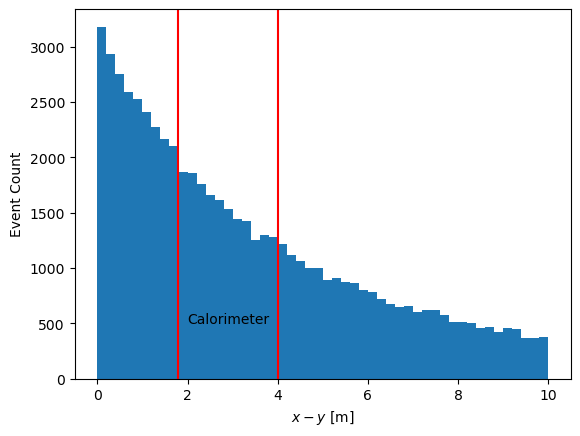

In [28]:
plt.hist(np.sqrt(llp_particles[abs(llp_particles.eta) < eta_central_split].Lxy), bins=50, range=(0, 10))
plt.xlabel('$x-y$ [m]')
plt.ylabel('Event Count')

# Lines to describe the central and forward areas
plt.axvline(lxy_limits[0], color='red')
plt.axvline(lxy_limits[1], color='red')

mid_point_cal = lxy_limits[0] + (lxy_limits[1]-lxy_limits[0])/2.0

plt.text(mid_point_cal, 500, 'Calorimeter', horizontalalignment='center')

plt.show()

Notice the statistics aren't that great - a bit ratty. Probably 50 bins is too much.

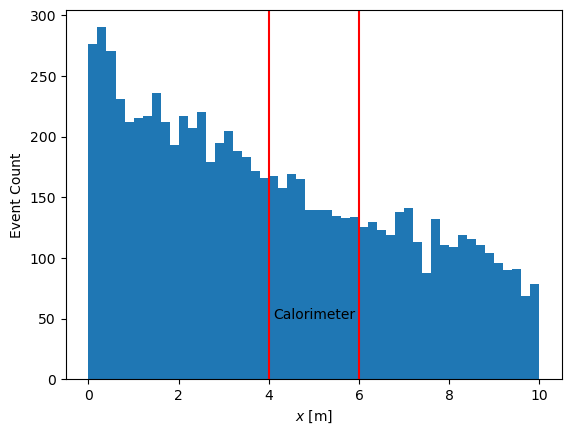

In [21]:
plt.hist(llp_particles[abs(llp_particles.eta) > eta_central_split].Lz, bins=50, range=(0, 10))
plt.xlabel('$x$ [m]')
plt.ylabel('Event Count')

# Lines to describe the central and forward areas
plt.axvline(lz_limits[0], color='red')
plt.axvline(lz_limits[1], color='red')

mid_point_cal = lz_limits[0] + (lz_limits[1]-lz_limits[0])/2.0

plt.text(mid_point_cal, 50, 'Calorimeter', horizontalalignment='center')

plt.show()